# Lale: Library for Semi-Automated Data Science

Martin Hirzel, Kiran Kate, Avi Shinnar, Guillaume Baudart, and Pari Ram

5 November 2019

Examples, documentation, code: https://github.com/ibm/lale

<img src="../docs/img/lale_logo.jpg" alt="logo" width="140px" align="left"/>

## Value Proposition

The **target user** of Lale is the working data scientist. The
**scope** of Lale includes machine learning (both deep learning and
non-DL) and data preparation. The **value** of Lale encompasses:

<img src="img/2019-1105-three-values.png" style="width:350px" align="left">

## Categorical + Continuous Dataset

In [1]:
import lale.datasets.openml
import pandas as pd
(train_X, train_y), (test_X, test_y) = lale.datasets.openml.fetch(
    'credit-g', 'classification', preprocess=False)
# print last five rows of labels in train_y and features in train_X
pd.concat([pd.DataFrame({'y': train_y}, index=train_X.index).tail(5),
           train_X.tail(5)], axis=1)

,y,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,...,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
835,0,<0,12.0,no credits/all paid,new car,1082.0,<100,1<=X<4,4.0,male single,...,4.0,car,48.0,bank,own,2.0,skilled,1.0,none,yes
192,0,0<=X<200,27.0,existing paid,business,3915.0,<100,1<=X<4,4.0,male single,...,2.0,car,36.0,none,own,1.0,skilled,2.0,yes,yes
629,1,no checking,9.0,existing paid,education,3832.0,no known savings,>=7,1.0,male single,...,4.0,real estate,64.0,none,own,1.0,unskilled resident,1.0,none,yes
559,0,0<=X<200,18.0,critical/other existing credit,furniture/equipment,1928.0,<100,<1,2.0,male single,...,2.0,real estate,31.0,none,own,2.0,unskilled resident,1.0,none,yes
684,1,0<=X<200,36.0,delayed previously,business,9857.0,100<=X<500,4<=X<7,1.0,male single,...,3.0,life insurance,31.0,none,own,2.0,unskilled resident,2.0,yes,yes


## Manual Pipeline

In [2]:
from sklearn.preprocessing import Normalizer as Norm
from sklearn.preprocessing import OneHotEncoder as OneHot
from sklearn.linear_model import LogisticRegression as LR
import lale.helpers
lale.helpers.wrap_imported_operators()

In [3]:
from lale.lib.lale import Project
from lale.lib.lale import ConcatFeatures as Concat

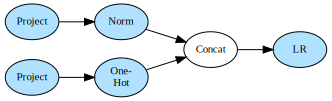

In [4]:
manual_trainable = (
       (  Project(columns={'type': 'number'}) >> Norm()
        & Project(columns={'type': 'string'}) >> OneHot())
    >> Concat
    >> LR(LR.penalty.l1, C=0.001))
lale.helpers.to_graphviz(manual_trainable)

In [5]:
import sklearn.metrics
manual_trained = manual_trainable.fit(train_X, train_y)
manual_y = manual_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, manual_y):.1%}')

accuracy 29.1%


## Pipeline Combinators

| Lale feature            | Name | Description  | Scikit-learn feature                 |
| ----------------------- | ---- | ------------ | ------------------------------------ |
| >> or `make_pipeline`   | pipe | feed to next | `make_pipeline`                      |
| & or `make_union`       | and  | run both     | `make_union` or `ColumnTransformer`  |
| &#x7c; or `make_choice` | or   | choose one   | N/A (specific to given Auto-ML tool) |

## Automated Pipeline

In [6]:
from xgboost import XGBClassifier as XGBoost
from sklearn.svm import LinearSVC
lale.helpers.wrap_imported_operators()

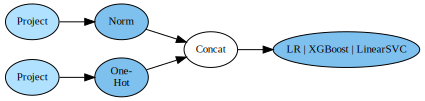

In [7]:
auto_planned = (
       (  Project(columns={'type': 'number'}) >> Norm
        & Project(columns={'type': 'string'}) >> OneHot)
    >> Concat
    >> (LR | XGBoost | LinearSVC))
lale.helpers.to_graphviz(auto_planned)

In [8]:
from lale.lib.lale.hyperopt_classifier import HyperoptClassifier
auto_optimizer = HyperoptClassifier(auto_planned, cv=3, max_evals=10)
auto_trained = auto_optimizer.fit(train_X, train_y)
auto_y = auto_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, auto_y):.1%}')

100%|██████████| 10/10 [00:36<00:00,  3.54s/it, best loss: -0.7373278347213325]
accuracy 75.2%


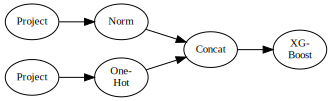

In [9]:
lale.helpers.to_graphviz(auto_trained)

In [10]:
import lale.pretty_print
lale.pretty_print.ipython_display(auto_trained, show_imports=False)

```python
project = Project(columns={'type': 'number'})
project_1 = Project_1(columns={'type': 'string'})
xgboost = XGBoost(colsample_bylevel=0.900172508121399, colsample_bytree=0.4645879165883061, learning_rate=0.3450371893786195, max_depth=10, min_child_weight=3, n_estimators=77, reg_alpha=0.9807177171317099, reg_lambda=0.5306129972505745, subsample=0.7957033383112613)
pipeline = ((project >> Norm) & (project_1 >> OneHot)) >> Concat >> xgboost
```

## Bindings as Lifecycle

<img src="img/2019-1105-bindings.png" style="width:450px" align="left">

## 20 Newsgroups Dataset

In [11]:
import sklearn.datasets
news = sklearn.datasets.fetch_20newsgroups()
news_X, news_y = news.data, news.target
pd.DataFrame({'y': [news.target_names[i] for i in news_y], 'X': news_X}).head()

,y,X
0,rec.autos,From: lerxst@wam.umd.edu (where's my thing)\nS...
1,comp.sys.mac.hardware,From: guykuo@carson.u.washington.edu (Guy Kuo)...
2,comp.sys.mac.hardware,From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3,comp.graphics,From: jgreen@amber (Joe Green)\nSubject: Re: W...
4,sci.space,From: jcm@head-cfa.harvard.edu (Jonathan McDow...


## Constraints in Scikit-learn

In [12]:
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.linear_model

In [13]:
sklearn_misconfigured = sklearn.pipeline.make_pipeline(
    sklearn.feature_extraction.text.TfidfVectorizer(),
    sklearn.linear_model.LogisticRegression(solver='sag', penalty='l1'))
print('no error detected yet')

no error detected yet


In [14]:
%%time
import sys
try:
    sklearn_misconfigured.fit(news_X, news_y)
except ValueError as e:
    print(e, file=sys.stderr)

CPU times: user 4.95 s, sys: 250 ms, total: 5.2 s
Wall time: 5.52 s


Solver sag supports only l2 penalties, got l1 penalty.


## Constraints in AI Automation

**Problem:** Some automated iterations raise exceptions.

**Solution 1:** Unconstrained search space

- {solver: \[linear, sag, lbfgs\], penalty: \[l1, l2\]}
- catch exception
- return made-up loss `np.float.max`

**Solution 2:** Constrained search space

- {solver: \[linear, sag, lbfgs\], penalty: \[l1, l2]\} **and** (**if** solver: [sag, lbfgs] **then** penalty: [l2])}
- no exceptions
- no made-up loss

## Constraints in Lale

In [15]:
from lale.lib.sklearn import TfidfVectorizer as Tfidf

In [16]:
%%time
import jsonschema
try:
    lale_misconfigured = Tfidf >> LR(LR.solver.sag, LR.penalty.l1)
except jsonschema.ValidationError as e:
    print(e.message, file=sys.stderr)

CPU times: user 31.2 ms, sys: 15.6 ms, total: 46.9 ms
Wall time: 28.6 ms


Invalid configuration for LR(solver='sag', penalty='l1') due to constraint the newton-cg, sag, and lbfgs solvers support only l2 penalties.
Schema of constraint 1: {
    'description': 'The newton-cg, sag, and lbfgs solvers support only l2 penalties.',
    'anyOf': [{
        'type': 'object',
        'properties': {
            'solver': {
                'not': {
                    'enum': ['newton-cg', 'sag', 'lbfgs']}}}}, {
        'type': 'object',
        'properties': {
            'penalty': {
                'enum': ['l2']}}}],
}
Value: {'solver': 'sag', 'penalty': 'l1', 'dual': False, 'C': 1.0, 'tol': 0.0001, 'fit_intercept': True, 'intercept_scaling': 1.0, 'class_weight': None, 'random_state': None, 'max_iter': 100, 'multi_class': 'ovr', 'verbose': 0, 'warm_start': False, 'n_jobs': None}


## Hyperparameter Schemas

In [17]:
XGBoost.hyperparam_schema('n_estimators')

{'description': 'Number of trees to fit.',
 'type': 'integer',
 'default': 100,
 'minimumForOptimizer': 10,
 'maximumForOptimizer': 1500}

In [18]:
XGBoost.hyperparam_schema('booster')

{'description': 'Specify which booster to use.',
 'enum': ['gbtree', 'gblinear', 'dart'],
 'default': 'gbtree'}

## Types as Search Spaces

<img src="img/2019-1105-search-spaces.png" style="width:550px" align="left">

## Customizing Schemas

In [19]:
import lale.schemas as schemas
Grove = XGBoost.customize_schema(
    n_estimators=schemas.Int(min=2, max=6),
    booster=schemas.Enum(['gbtree']))

In [20]:
grove_planned = ( Project(columns={'type': 'number'}) >> Norm
                & Project(columns={'type': 'string'}) >> OneHot
                ) >> Concat >> Grove

In [21]:
grove_optimizer = HyperoptClassifier(grove_planned, cv=3, max_evals=10)
grove_trained = grove_optimizer.fit(train_X, train_y)
grove_y = grove_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, grove_y):.1%}')

100%|██████████| 10/10 [00:29<00:00,  2.71s/it, best loss: -0.7358263933376041]
accuracy 71.2%


In [22]:
lale.pretty_print.ipython_display(grove_trained, show_imports=False)

```python
project = Project(columns={'type': 'number'})
norm = Norm(norm='max')
project_1 = Project_1(columns={'type': 'string'})
xgboost = XGBoost(booster='gbtree', colsample_bylevel=0.6016063807304212, colsample_bytree=0.7763972782064467, learning_rate=0.16389357351003786, max_depth=10, min_child_weight=5, n_estimators=4, reg_alpha=0.10485915855270356, reg_lambda=0.9268502695024392, subsample=0.4503841871781402)
pipeline = ((project >> norm) & (project_1 >> OneHot)) >> Concat >> xgboost
```

## Scikit-learn Compatible Interoperability

<img src="img/2019-1105-interop.png" style="width:550px" align="left">

## Summary

Examples, documentation, code: https://github.com/ibm/lale

<img src="img/2019-1105-summary.png" style="width:350px" align="left">